# ROC AOC Pre-processing 

# Intoduction to regrssion on feature Label

The hope here is that we've grabbed data, decided on the valuable data, created some new valuable data through manipulation, and now we're ready to actually begin the machine learning process with regression. First, we're going to need a few more imports. All imports now:



In this project we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

    https://www.kaggle.com/c/higgs-boson/data
    http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this project is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

    http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

Part 1: Data preparation (5 points)

Create a data preparation and cleaning function that does the following:

    Has a single input that is a file name string
    Reads data (the data is comma separated, has a row header and the first column EventID is the index) into a pandas dataframe
    Cleans the data
        Convert the feature Label to numeric (choose the minority class to be equal to 1)
            Create a feature Y with numeric label
            Drop the feature Label
        If a feature has missing values (i.e., -999):
            Create a dummy variable for the missing value
                Call the variable orig_var_name + _mv where orig_var_name is the name of the actual var with a missing value
                Give this new variable a 1 if the original variable is missing
            Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' .replace() function useful.
    After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
    Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.


In [3]:
%load_ext snakeviz
import pandas as pd
from sklearn import preprocessing 
import numpy as np


%%snakeviz
def replace(dataset):
    naan = -999.0                   #Missing  values
    fields = dataset.columns.values
    for f in fields:
        if (sum((dataset[f] == naan)) > 0 and f !='Y'):
            mu_f = dataset[f][(dataset[f] != naan)].mean() # mean values of the columns
            dataset[f + "_mv"] = (dataset[f] == naan)*1     #adding the _mv columns for the columns with -999 values
            dataset[f] = dataset[f].replace(to_replace=naan, value=mu_f) #replacing the -999 values with mu_f
    
    return dataset
    
def cleanBosonData(infile_name):
    data_read = pd.read_csv(infile_name, index_col = 0) #mentioning that index is column 0
    Y = (data_read['Label'] == 's')*1
    data_noY = data_read.drop('Label', 1) #dropping the target variable before replacing and scaling
    Fcall_data = replace(data_noY)
    
    fields = Fcall_data.columns        
    scl = preprocessing.StandardScaler() #instance of preprocessing
    data_clean = pd.DataFrame(scl.fit_transform(Fcall_data), columns = fields)
    data_clean['Y'] = Y.values #adding back the target variable column to the dataset

    return data_clean


            

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


UsageError: Line magic function `%%snakeviz` not found.


Why Scaling

Most of the times, your dataset will contain features highly varying in magnitudes, units and range. But since, most of the machine learning algorithms use Eucledian distance between two data points in their computations, this is a problem.

If left alone, these algorithms only take in the magnitude of features neglecting the units. The results would vary greatly between different units, 5kg and 5000gms. The features with high magnitudes will weigh in a lot more in the distance calculations than features with low magnitudes.
Tiny Features vs Mega Features

To supress this effect, we need to bring all features to the same level of magnitudes. This can be acheived by scaling.
How to Scale Features

There are four common methods to perform Feature Scaling.

    Standardisation:

Standardisation replaces the values by their Z scores.

This redistributes the features with their mean μ = 0 and standard deviation σ =1 . sklearn.preprocessing.scale helps us implementing standardisation in python.

2. Mean Normalisation:

This distribution will have values between -1 and 1with μ=0.

Standardisation and Mean Normalization can be used for algorithms that assumes zero centric data like Principal Component Analysis(PCA).

3. Min-Max Scaling:

This scaling brings the value between 0 and 1.

4. Unit Vector:

Scaling is done considering the whole feature vecture to be of unit length.

Min-Max Scaling and Unit Vector techniques produces values of range [0,1]. When dealing with features with hard boundaries this is quite useful. For example, when dealing with image data, the colors can range from only 0 to 255.
When to Scale

Rule of thumb I follow here is any algorithm that computes distance or assumes normality, scale your features!!!

Some examples of algorithms where feature scaling matters are:

    k-nearest neighbors with an Euclidean distance measure is sensitive to magnitudes and hence should be scaled for all features to weigh in equally.
    Scaling is critical, while performing Principal Component Analysis(PCA). PCA tries to get the features with maximum variance and the variance is high for high magnitude features. This skews the PCA towards high magnitude features.
    We can speed up gradient descent by scaling. This is because θ will descend quickly on small ranges and slowly on large ranges, and so will oscillate inefficiently down to the optimum when the variables are very uneven.
    Tree based models are not distance based models and can handle varying ranges of features. Hence, Scaling is not required while modelling trees.
    Algorithms like Linear Discriminant Analysis(LDA), Naive Bayes are by design equipped to handle this and gives weights to the features accordingly. Performing a features scaling in these algorithms may not have much effect.

Hope you understood the why, how and when of feature scaling.

I would love to hear more about your best practices and rules of thumb. Please comment below to enlighten us all with the same.

In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1. Clean the two data files included in this assignment (data/boson_training_cut_2000.csv and data/boson_testing_cut.csv) and use them as training and testing data sets.


In [14]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")
print(data_test.head())
print(data_train.head())

   DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h  \
0 -1.213348e-01                     1.455304      0.099593 -0.447028   
1 -1.067373e+00                    -0.715757     -0.854408 -0.103307   
2 -1.159847e-01                     0.480365      0.064286 -0.297389   
3  8.355185e-01                     0.476970      0.482975 -0.882260   
4 -7.331470e-15                     0.925326     -0.484386 -0.473912   

   DER_deltaeta_jet_jet  DER_mass_jet_jet  DER_prodeta_jet_jet  \
0              0.000000     -2.659827e-16         4.017959e-16   
1              0.000000     -2.659827e-16         4.017959e-16   
2             -0.287484      6.645349e-01        -7.332925e-02   
3              0.000000     -2.659827e-16         4.017959e-16   
4              0.000000     -2.659827e-16         4.017959e-16   

   DER_deltar_tau_lep  DER_pt_tot  DER_mass_MMC_mv  DER_deltaeta_jet_jet_mv  \
0            0.007415    0.498029        -0.422979                 0.641958   
1           

In [1]:
%timeit cleanBosonData()

NameError: name 'cleanBosonData' is not defined

2. On the training set, build the following models:

    A logistic regression using sklearn's linear_model.LogisticRegression(). For this model, use C=1e30.
    An SVM using sklearn's svm.svc(). For this model, specify that kernel="linear".

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.


F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


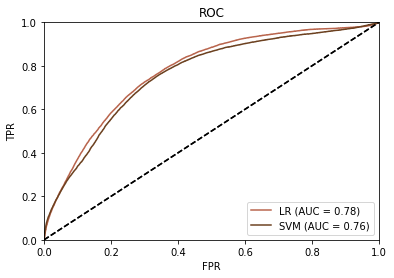

In [15]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model,svm
from sklearn import metrics

target_var = "Y"
actual = data_test["Y"].copy()
#Scikit-learn deliberately does not support statistical inference. If you want out-of-the-box coefficients significance tests (and much more), you can use Logit estimator from Statsmodels. This package mimics interface glm models in R, so you could find it familiar.
#If you still want to stick to scikit-learn LogisticRegression, you can use asymtotic approximation to distribution of maximum likelihiood estimates. Precisely, for a vector of maximum likelihood estimates theta, its variance-covariance matrix can be estimated as inverse(H), where H is the Hessian matrix of log-likelihood at theta. This is exactly what the function below does

clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(data_train.drop(target_var,1),data_train[target_var])
predictions = clf_LR.predict_proba(data_test.drop(target_var,1))[:,1]

clf_svm = svm.SVC(kernel='linear')
clf_svm.fit(data_train.drop(target_var,1),data_train[target_var])
predictions_svm = clf_svm.decision_function(data_test.drop(target_var,1))


def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
    roc_auc = metrics.auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
plotAUC(actual,predictions, 'LR')
plotAUC(actual,predictions_svm, 'SVM')
plt.show()



3. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

# Model selection with cross-validation 

1. Write a cross-validation function that does the following:

    Takes as inputs a dataset, a label name, # of splits/folds (k), a sequence of values for 𝐶

(cs)
Performs two loops

    Outer Loop: for each f in range(k):
        Splits the data into data_train & data_validate according to cross-validation logic
    Inner Loop: for each c in cs:
        Trains an SVM on training split with C=c, kernel="linear"
        Computes AUC_c_k on validation data
        Stores AUC_c_k in a dictionary of values

Returns a dictionary, where each key-value pair is: c:[auc-c1,auc-c2,..auc-ck]

In [ ]:
from sklearn.cross_validation import * 
def xValSVM(dataset, label_name, k, cs):
    try:
        n_samples = dataset.shape[0]
        cv = KFold(n = n_samples, n_folds = k)   #using the split method in KFold function
        #print(cv)
        aucs = {}

        for train_index, test_index in cv:    #Collecting indices of training and test sets from kfold function
            train_k = dataset.iloc[train_index] 
            test_k = dataset.iloc[test_index]
            #print (test_k.head())

            for c in cs:
                svm_clf = svm.SVC(kernel = 'linear', C = c)
                svm_clf.fit(train_k.drop(label_name, 1), train_k[label_name])
                met = metrics.roc_auc_score(test_k[label_name], svm_clf.decision_function(test_k.drop(label_name,1)))

                if c in aucs:
                    aucs[c].append(met) #appending the auc scores for each iteration
                else:
                    aucs[c] = [met]
    except:
        print("----------Error in xValSVM-------------------")
        
    return aucs

2. Using the function written above, do the following:

    Generate a sequence of 10 𝐶

    values in the interval [10^(-8), ..., 10^1] (i.e., do all powers of 10 from -8 to 1).
    Call aucs = xValSVM(train, ‘Y’, 10, cs)
    For each c in cs, get mean(AUC) and StdErr(AUC)
    Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
    Generate a plot with the following: a. Log10(c) on the x-axis b. 1 series with mean(AUC) for each c c. 1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern) d. 1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern) e. a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 
    
    

In [ ]:
dict_values = {'val':[], 'mean':[], 'stderr':[]}
folds = 10
powers = range(-8,2)
cs = [10**i for i in powers]
aucs_sv = xValSVM(data_train,"Y",folds,cs)

for i in powers:
    dict_values['val'].append(i)                                             #value of powers of C
    dict_values['mean'].append(np.array(aucs_sv[10**i]).mean())              #means
    dict_values['stderr'].append(np.sqrt(np.array(aucs_sv[10**i]).var()/10)) #standard errors
    
means = np.array(dict_values['mean'])
cs = np.array(dict_values['val'])       #converting all the values to Numpy arrays
stderr = np.array(dict_values['stderr'])

max_val = (means-stderr).max() #finding max(AUC-StdErr(AUC))

#c_val_for_bootfunc = np.array(cs)[(means>max_val)].min() - will be 0.1

plt.plot(dict_values['val'], means, label = 'means')
plt.plot(dict_values['val'], means+stderr, 'k+-', label = 'means+stderr')
plt.plot(dict_values['val'], means-stderr, 'k--', label = 'means-stderr')
plt.plot(dict_values['val'], max_val*np.ones(len(means)), 'r', label = 'reference line') #for the reference line
plt.legend(loc = 'lower right')
plt.xlabel('Log10(c)')
plt.ylabel('roc_auc_score')
    

# Learning Curve with Bootstrapping

n this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set. As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more. We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size 𝑁
, we test the performance of a model trained on a subsample of size 𝑁𝑖, where 𝑁𝑖<=𝑁. We can plot how performance grows as we move 𝑁𝑖 from 0 to 𝑁

.

Because of the inherent randomness of subsamples of size 𝑁𝑖
, we should expect that any single sample of size 𝑁𝑖 might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size 𝑁𝑖

, build a model, evaluate on a test set, and then take an average and standard error of the results.

1. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

    Takes as input:
        A master training file (train)
        A master testing file (test)
        Number of bootstrap iterations (nruns)
        Size of a bootstrap sample (sampsize)
        An indicator variable to specific LR or SVM (lr=1)
        A c option (only applicable to SVM)

    Runs a loop with (nruns) iterations, and within each loop:
        Sample (sampsize) instances from train, with replacement
        Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.
        Computes AUC on test data using predictions from model in above step
        Stores the AUC in a list

    Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples



In [ ]:
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    target = 'Y'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (lr == 1):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Linear regression fitting and predicting if lr==1
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        else:
            svm_i = svm.SVC(kernel='linear', C = 0.1) #hardcoding the value since it is negative power error.
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

2. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:

    Log2(samplesize) on the x-axis
    2 sets of results lines, one for LR and one for SVM, the set should include
        1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
        1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
        1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)



F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklea

F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklea

F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklea

F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
F:\Anaconda\lib\site-packages\sklea

Text(0, 0.5, 'roc_auc_score')

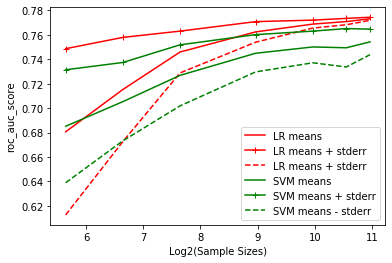

In [17]:
SampleSizes = [50, 100, 200, 500, 1000, 1500, 2000]

LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(data_train, data_test, 20, n, 1, 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(data_train, data_test, 20, n, 0, 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-' , label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.legend(loc = 'lower right')
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')


#Even though it says Runtime error: Overflow encountered, please give sometime for the plot to be shown.


# Please scrooll down following the error message


3. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?

We can see that SVM is giving the best value for smallest sample size. But it is not the same case for all the smaller sample sizes. Logistic regression does better for most of the sample sizes.

The performance reaches maximum point for both the algorithms. So doubling the data will likely not add anything to the performance of the algorithms. Also we don't know increase in auc would be worth interms of dollars.So we can't clearly say if it is a worthy investment.

Note : the plot varied each time i executed because of the random indexes we are taking in modBootstrapper( ) function

4. Is there a reason why cross-validation might be biased? If so, in what direction is it biased?

If k is number of folds, Cross-validation only uses (k-1)/k% of the data for training. Because of using subset of the actual data, we get slightly bias in cross validation. If the learning curve won’t reach the plateau at (k-1)/k% of the data, then the cross-validation procedure will be negatively biased due to the smaller training sample sizes. 

In [18]:
#references :
# 2.2 : http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html,
# 2.2 : https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
# Part 3: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection
#      : https://www.youtube.com/watch?v=Gol_qOgRqfA
# 4.1 & 4.2 : # took most of the code from  "Lecture_ERM_LogReg_3_6053_fall17.ipynb" notebook discussed in class.
# 4.3 : https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
# 4.4 :  https://en.wikipedia.org/wiki/Cross-validation_(statistics)



In regards to the data obtained by the following stats, we find that there might be a biased output obtained so in regards to the above-obtained statistics we can conclude that SVM is giving a better value proposition for small sample data size. but it is not the case for all the small sample size, LogisticRegression makes the best output performance for any given small data size 

# DOES DOUBLING THE DATA INCREASE THE CHANCE OF  BETER PERFORMANCE ON ANY MODEL?

The performance reaches a maximum point for both the algorithms. So doubling the data will likely not add anything to the performance of the algorithms. Also, we don't know the increase in AUC would be worth in terms of dollars. So we can't clearly say if it is a worthy investment.


# About Higgs Boson particle 

Higgs boson is an elementary particle in Standard model of particle physics, produced by the quantum excitation of the higgs filed 